In [1]:
import xarray as xr
from healpy import visufunc
import matplotlib.pyplot as plt
import os

## Load Zarr Data

In [ ]:
save_path = "./data"
zarr_path = os.path.join(save_path, f"era5_healpix_q.zarr")

hp_ds_8 = xr.open_zarr(
    zarr_path,
    group=f"nside=8",
)
hp_ds_16 = xr.open_zarr(
    zarr_path,
    group=f"nside=16",
)

# optional: sort by time
hp_ds_8 = hp_ds_8.sortby("time")
hp_ds_16 = hp_ds_16.sortby("time")

# Data Plotting

### Plotting Function

In [10]:
def plot_comparison(hp_ds, og_ds, level, time):
    # original lat-lon data
    og_sel = og_ds["q"].sel(
        valid_time=time,
        pressure_level=level,
    )
    og_data = og_sel.values
    lat = og_sel.latitude.values
    lon = og_sel.longitude.values

    fig = plt.figure(figsize=(25, 6))

    ax1 = fig.add_subplot(1, 3, 1)
    pcm = ax1.pcolormesh(
        lon, lat, og_data,
        shading="auto"
    )
    ax1.set_title("Original lat–lon (ERA5)")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    fig.colorbar(pcm, ax=ax1, orientation="vertical", fraction=0.046)

    # healpix regridded
    m = hp_ds["q"].sel(
        time=time,
        level=level,
    ).values

    ax2 = fig.add_subplot(1, 3, 2)
    visufunc.mollview(
        m,
        fig=fig,
        sub=(1, 3, 2),
        title="HEALPix regridded (mollview)",
        unit="q",
        hold=True
    )

    ax3 = fig.add_subplot(1, 3, 3)
    visufunc.cartview(
        m,
        fig=fig,
        sub=(1, 3, 3),
        title="HEALPix regridded (cartview)",
        unit="q",
        hold=True
    )

    plt.suptitle(f"Specific humidity at {level} hPa\n{time}", y=0.95)
    plt.show()

### NSIDE = 8 Plots

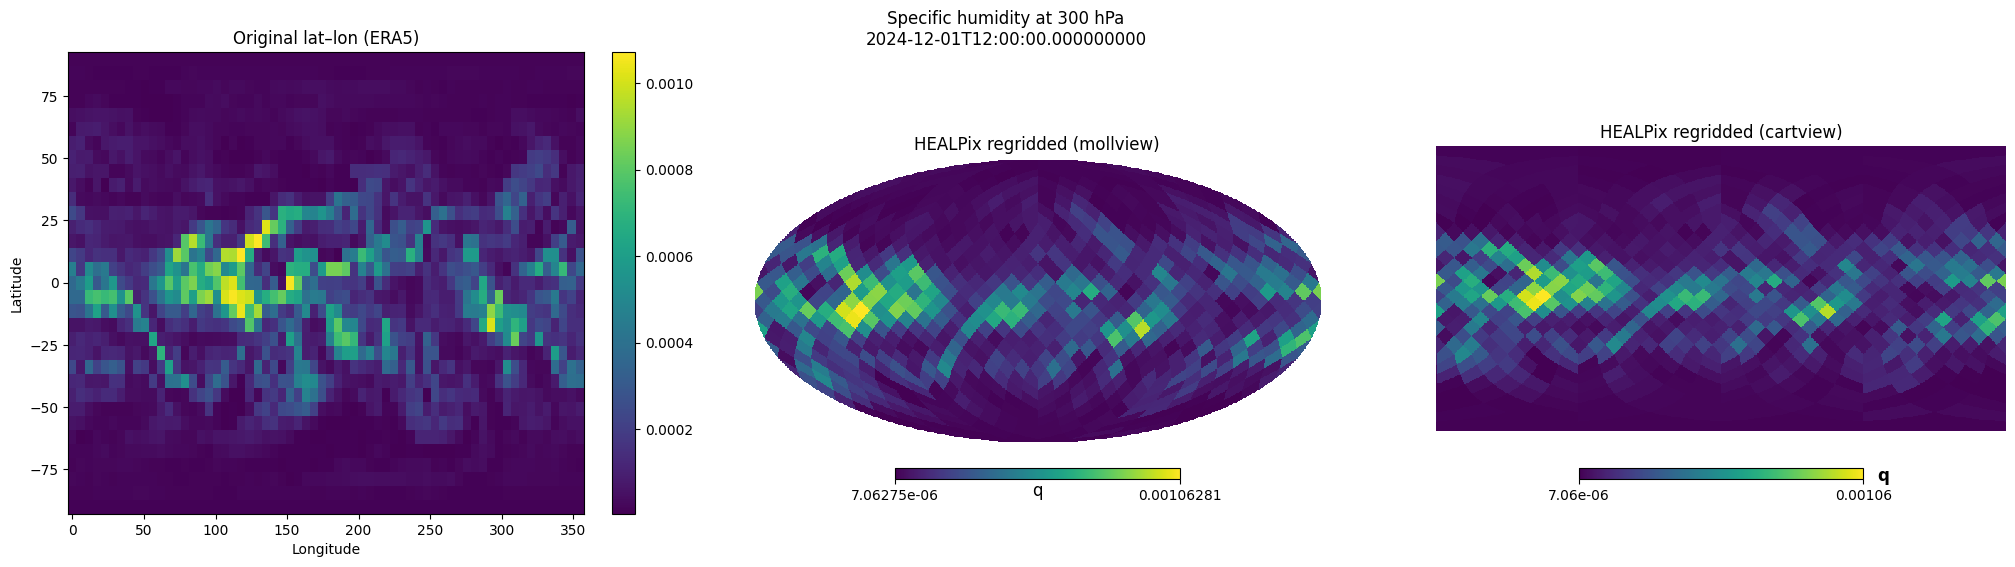

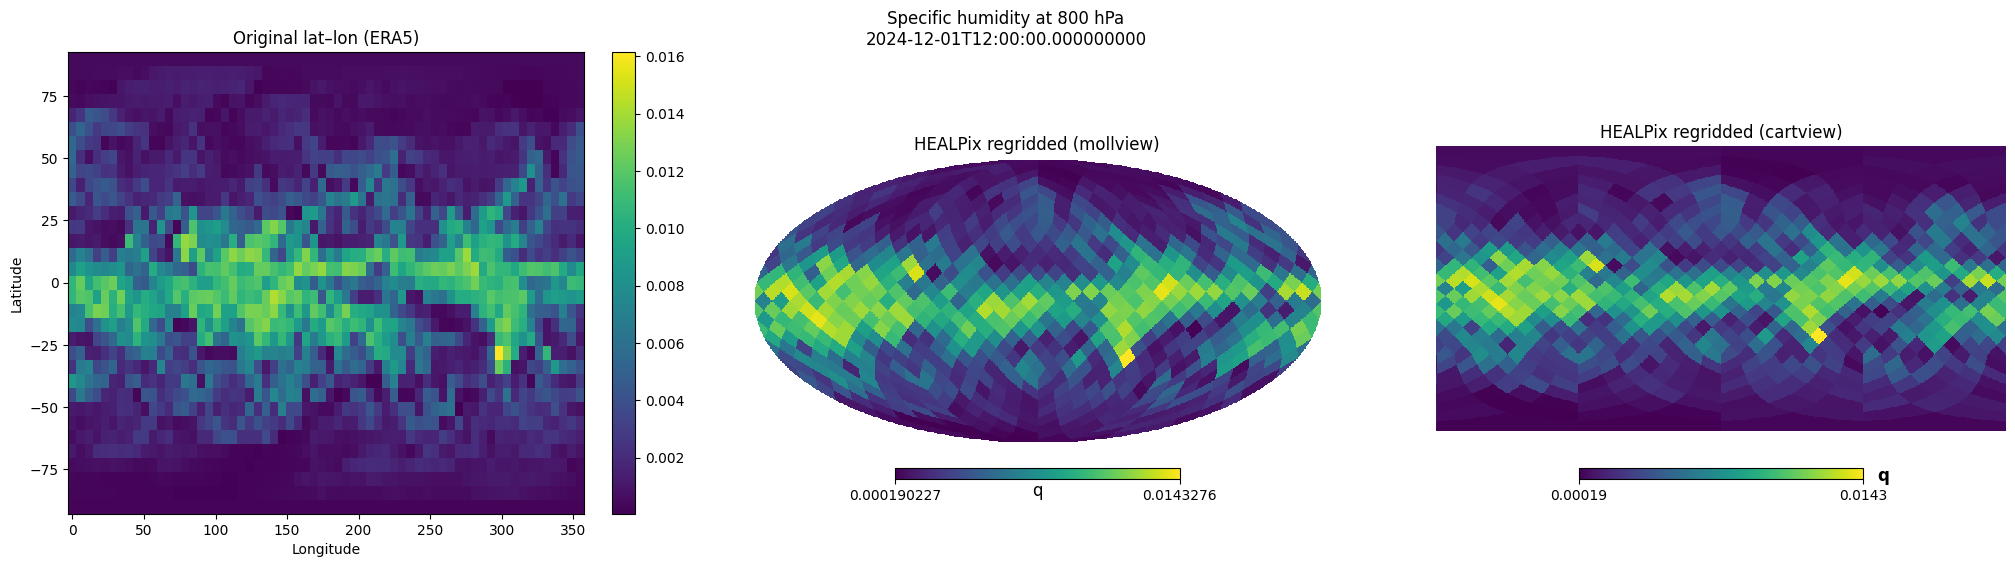

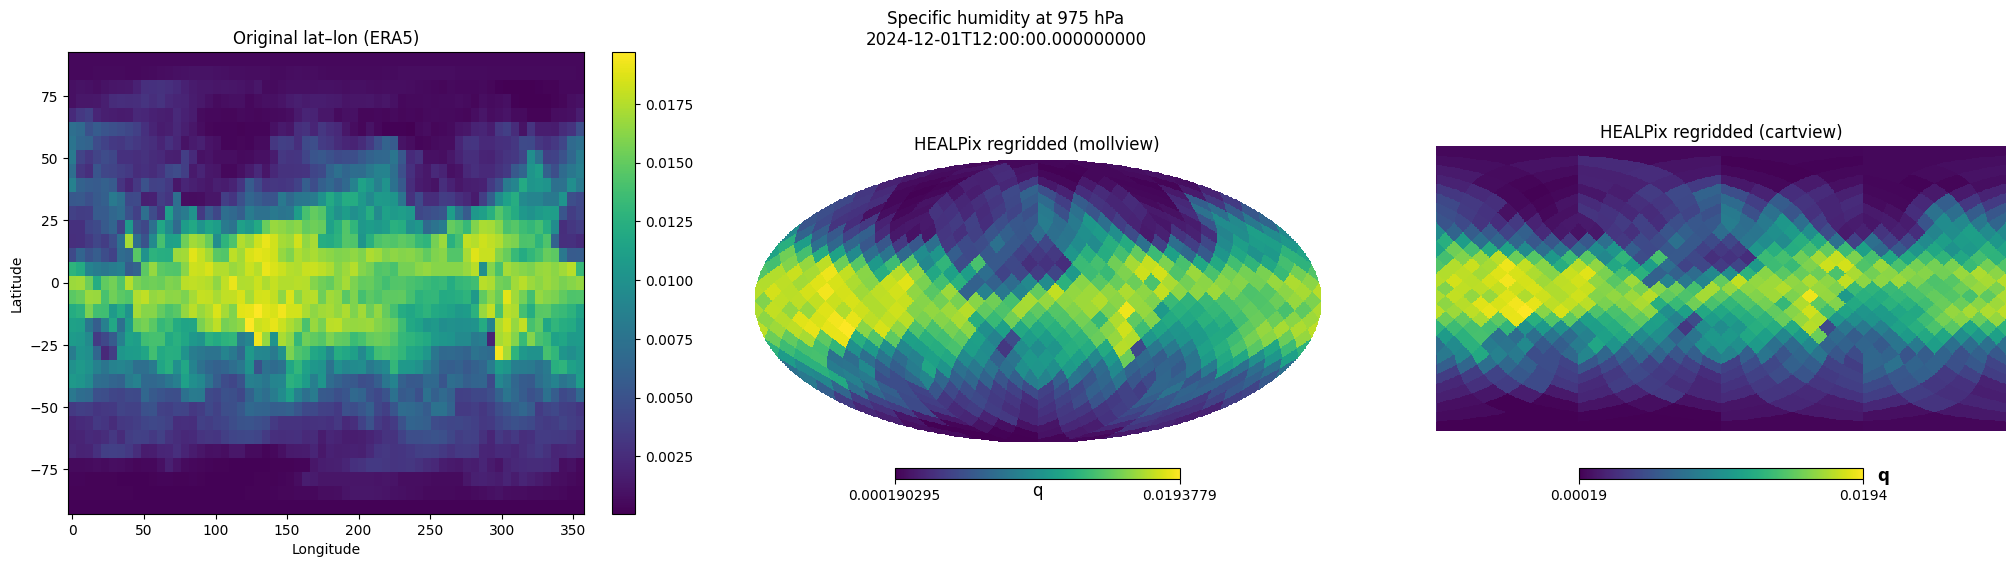

In [13]:
date = "2024-12-01"

og_ds = xr.open_dataset(
    os.path.join(save_path, f"{date}.nc")
)

time = f'{date}T12:00:00.000000000'

for level in [300, 800, 975]:
    plot_comparison(hp_ds_8, og_ds, level, time)

The projection to a healpix grid seems to have lost a bit of the detail from the original lat-lon data. Some of the patterns in the original data are clearly to be found also in the projected data, but not with the same level of detail. Also interesting is the impact of the averaging when multiple positions from the original data were assigned to the same healpix cell: in the second plot, the maximum value is approx. 0.016, while its only ~0.014 in the projection.

### NSIDE = 16 Plots

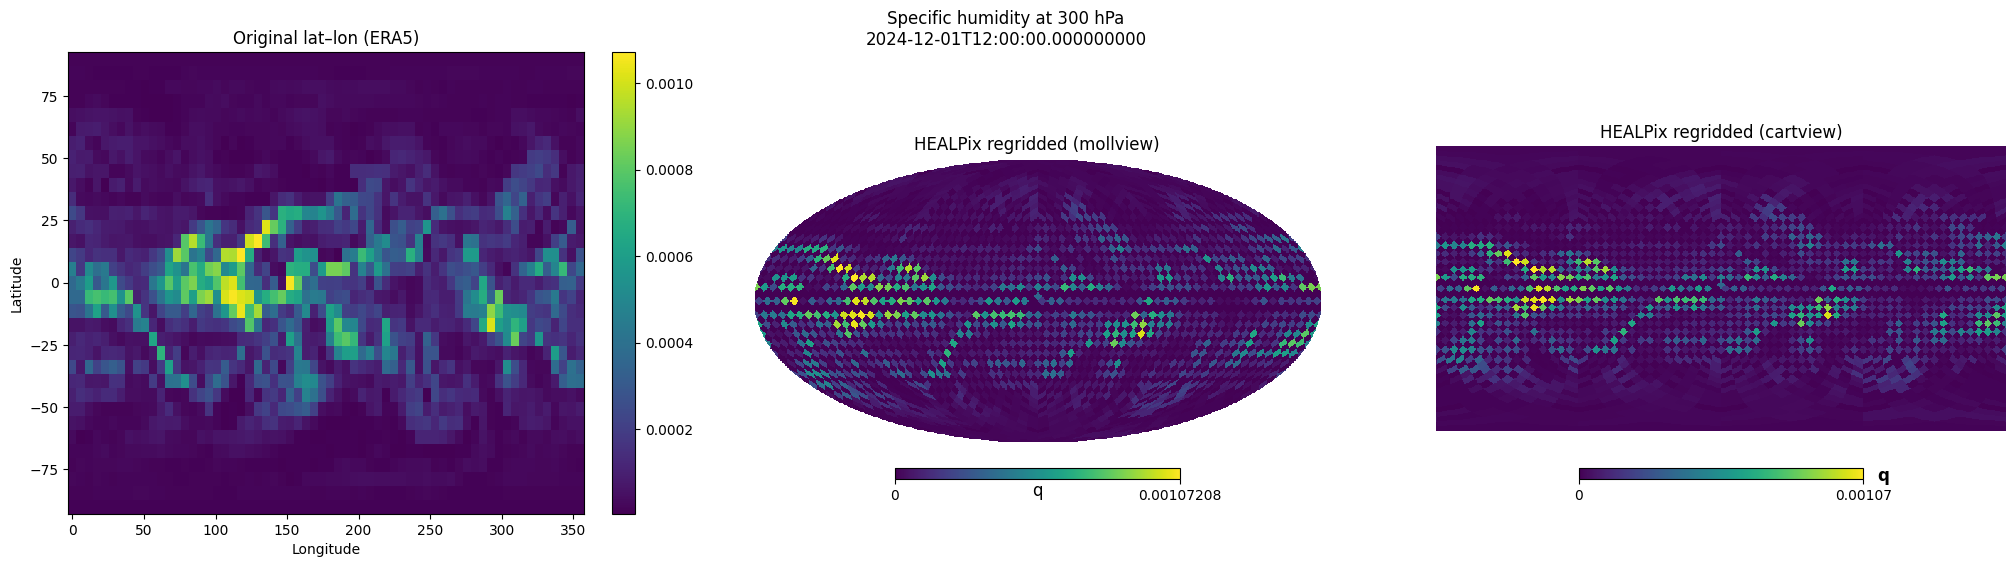

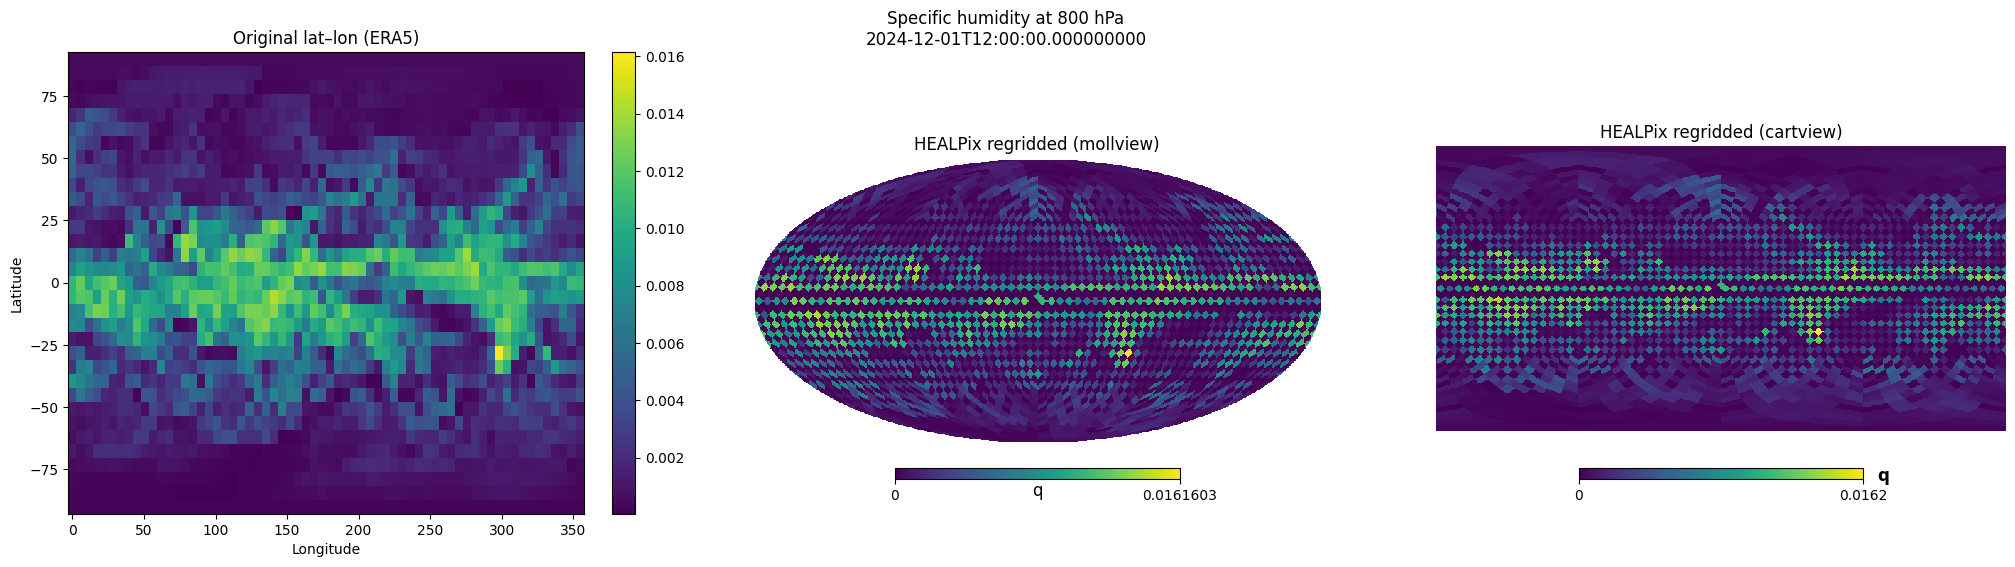

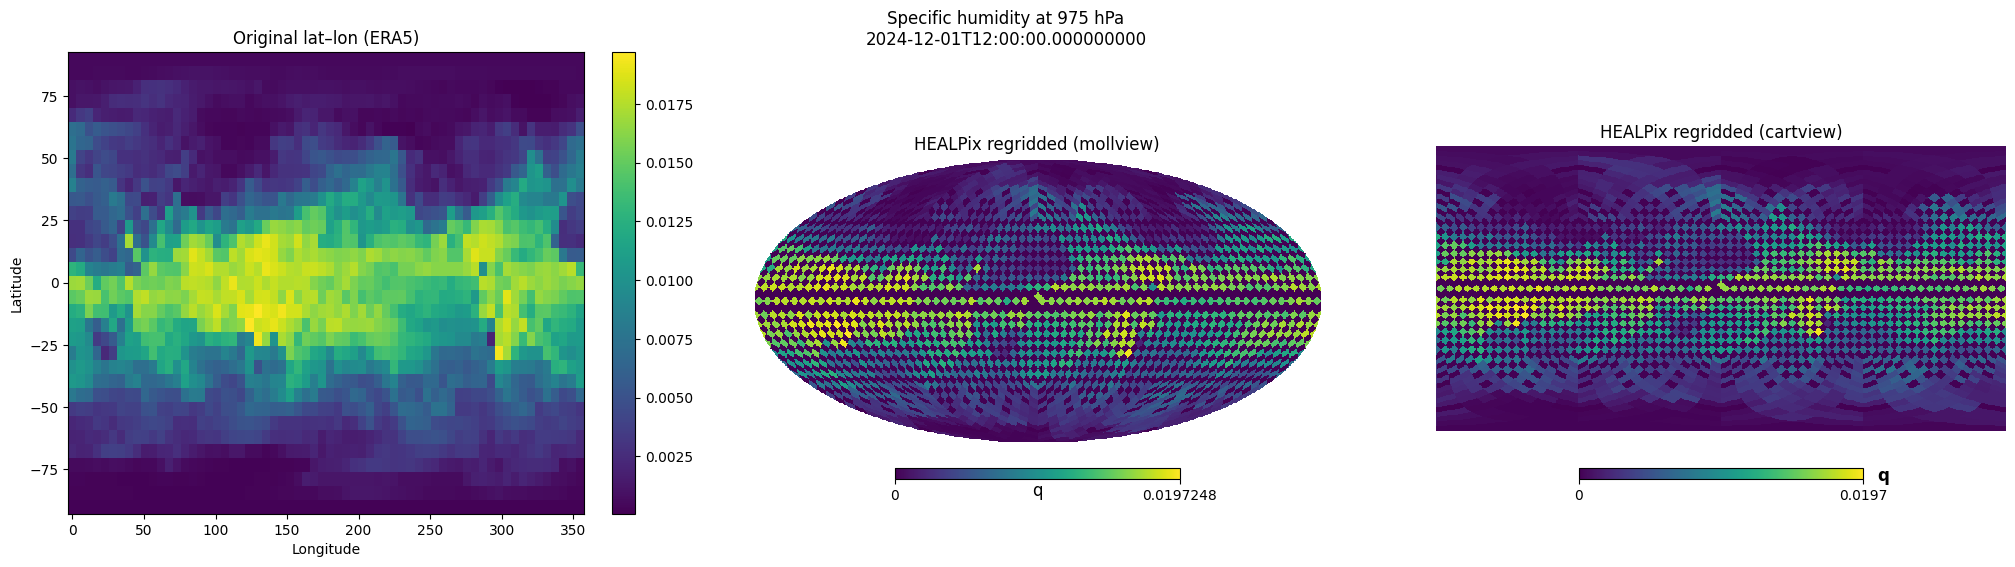

In [14]:
date = "2024-12-01"

og_ds = xr.open_dataset(
    os.path.join(save_path, f"{date}.nc")
) 

time = f'{date}T12:00:00.000000000'

for level in [300, 800, 975]:
    plot_comparison(hp_ds_16, og_ds, level, time)

With NSIDE=16, the resolution of the original data does not seem sufficient to populate the HEALPix grid completely, resulting in the gaps seen on the maps (i.e. no values from the original data array are assigned to these positions in the HEALPix grid), with the exception of the poles, where inherently higher longitudinal sampling density occurs due to meridian convergence.
Another point of interest is the change in orientation seen in all plots, where the original data seems to be mirrored along the y-axis.